In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from WelfareMeasures import *
from functions_njit import tax_rate_fct
from bernoulli_distribution import Bernoulli
from help_functions_non_njit import *
from graph_format import *
# load local model file and initialize model class
from model import ModelClass
from scipy.optimize import minimize

# Load original model

In [2]:
model = ModelClass() # set a few number of periods.

par = model.par
sol = model.sol
sim = model.sim
par.opt_tol = 1e-6
par.opt_maxiter = 1000

%time model.solve(do_print=False)
%time model.simulate()

CPU times: total: 12min 59s
Wall time: 3min 21s
CPU times: total: 46.3 s
Wall time: 28.9 s


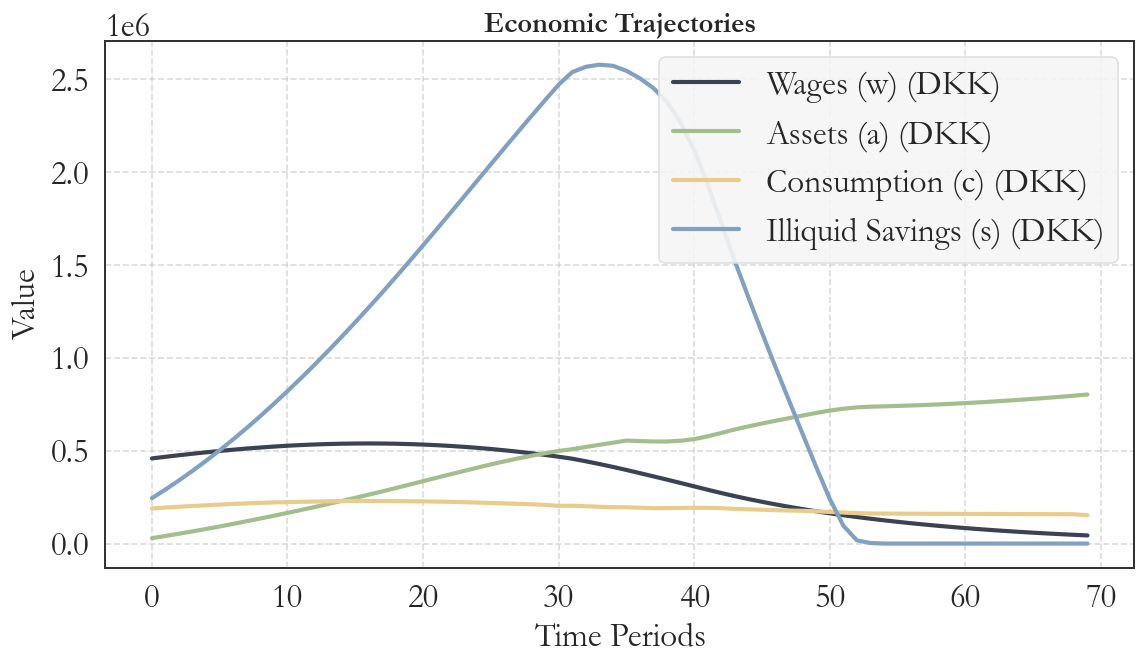

In [3]:
time = np.arange(par.T)
data_dict_basic = {
    "Wages (w)": {"data": np.mean(model.sim.w[:], axis=0), "unit": "DKK"},
    "Assets (a)": {"data": np.mean(model.sim.a[:], axis=0), "unit": "DKK"},
    "Consumption (c)": {"data": np.mean(model.sim.c[:], axis=0), "unit": "DKK"},
    "Illiquid Savings (s)": {"data": np.mean(model.sim.s[:], axis=0), "unit": "DKK"},
}

plot_simulation_one_graph(data_dict_basic, time, title="Economic Trajectories")

# Counter factual

In [4]:
# Change parameters and re-solve
theta = [1.]
theta_names = ['rho_ef']

og_model, new_model =  make_new_model(model, theta, theta_names, do_print = False)


# Labor supply

Expected welfare  before parameter changes: -22.129861373591353
Expected welfare after parameter changes: -22.133535179718034
Consumption at every age before the policy change must change with -0.1 pct. to keep the same utility, and analytically: -0.1 pct.


c:\Users\Peter\Design_retirement\WelfareMeasures.py:83: RuntimeWarning: Mean of empty slice
  sim_og_h = np.nanmean(sim_og_h_ex_1, axis=0)# age specific average
c:\Users\Peter\Design_retirement\WelfareMeasures.py:84: RuntimeWarning: Mean of empty slice
  sim_new_h = np.nanmean(sim_new_h_ex_1, axis=0) # age specific average


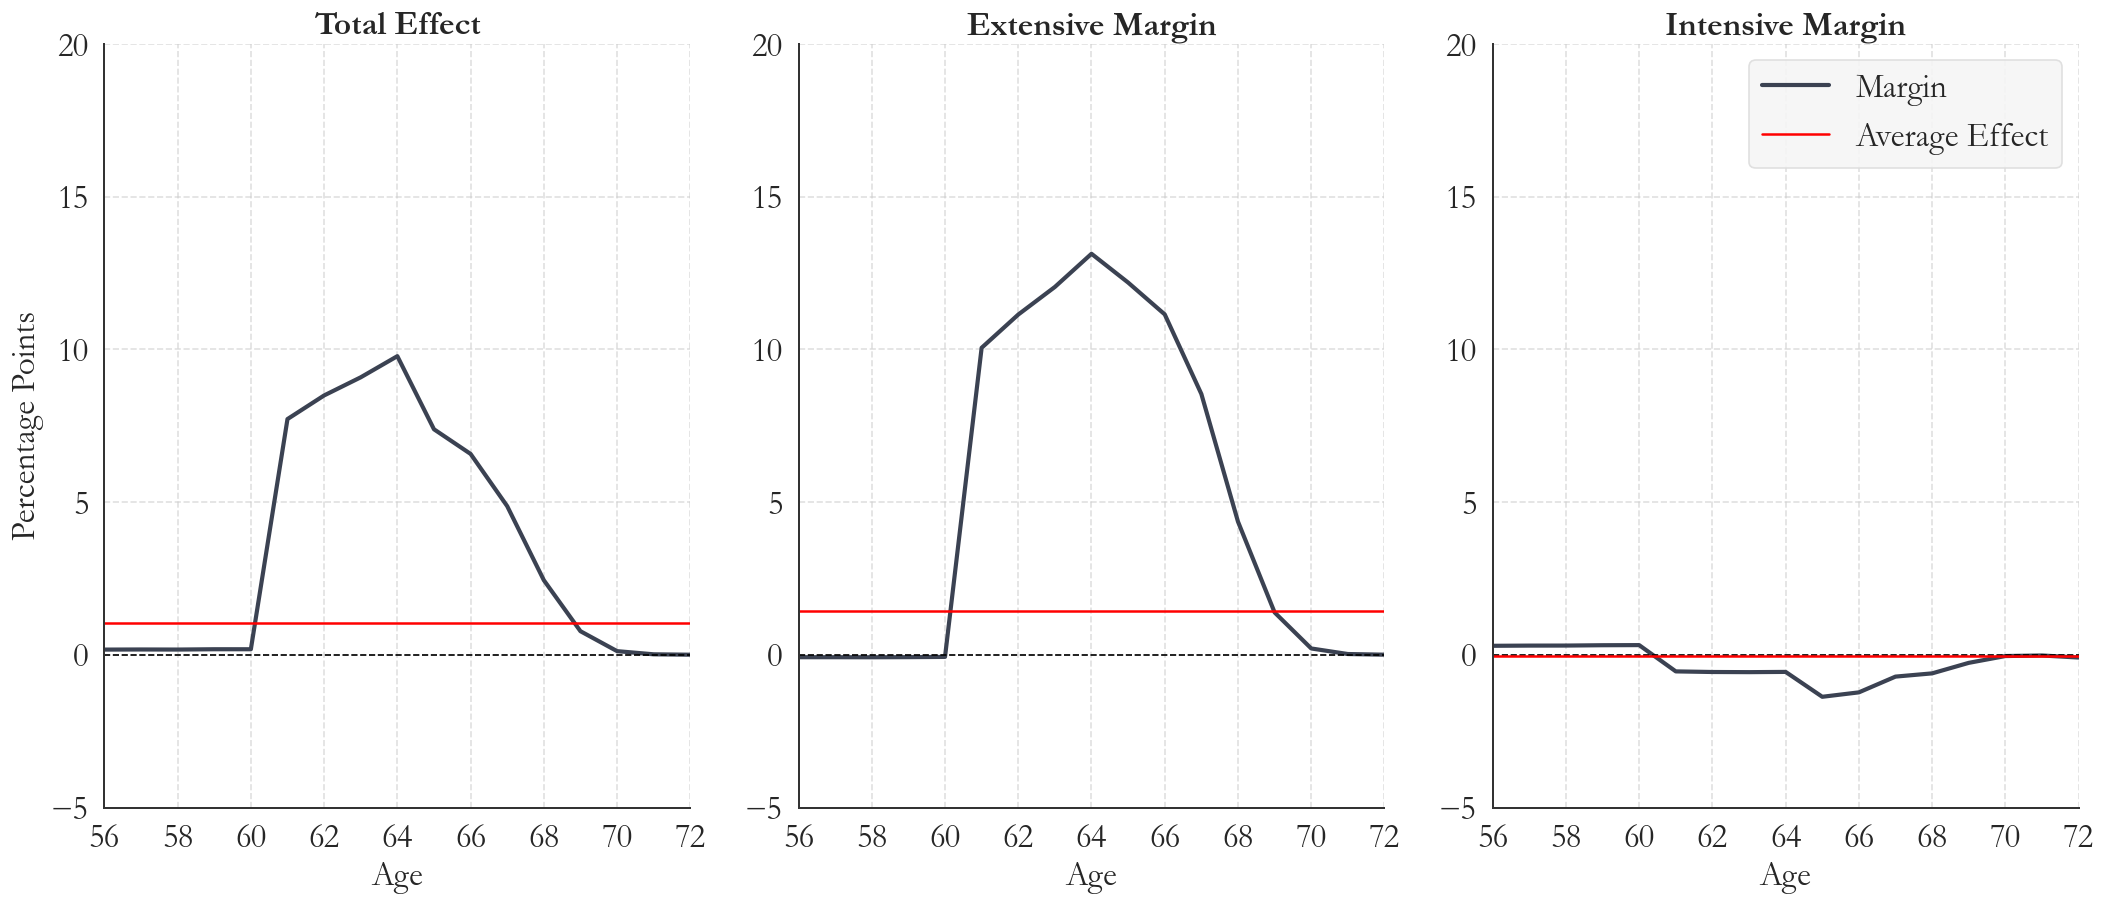

0.010521026950033147

In [5]:
# Compare models 
consumption_eq = find_consumption_equivalence(og_model, new_model, do_print= True, the_method = 'brentq')
intensive_margin, extensive_margin, total_margin, total_per_person, intensive_margin_age, extensive_margin_age, total_margin_age  = labor_elasticity(og_model, new_model)


plot_labor_margins_by_age(
    intensive_age=intensive_margin_age,
    extensive_age=extensive_margin_age,
    total_age=total_margin_age,
    avg_intensive=intensive_margin,
    avg_extensive=extensive_margin,
    avg_total=total_margin,
    age_start=par.start_age,
    # title_prefix="Labor Supply — ",
    save_title="CF_means_testing_labor.png",
    ylim_total=(-5, 20),
    ylim_extensive=(-5, 20),
    ylim_intensive=(-5, 20)
)

total_margin

In [6]:
pi_cum = np.cumprod(par.pi)
total_margin_og = np.mean(pi_cum[:og_model.par.last_retirement] * og_model.sim.h[:, :og_model.par.last_retirement])
total_margin_new = np.mean(pi_cum[:og_model.par.last_retirement] * new_model.sim.h[:, :og_model.par.last_retirement])
total_margin = (total_margin_new-total_margin_og)/total_margin_og
total_margin*100

2.280734493985663

# Consumption Equivalence - distribution

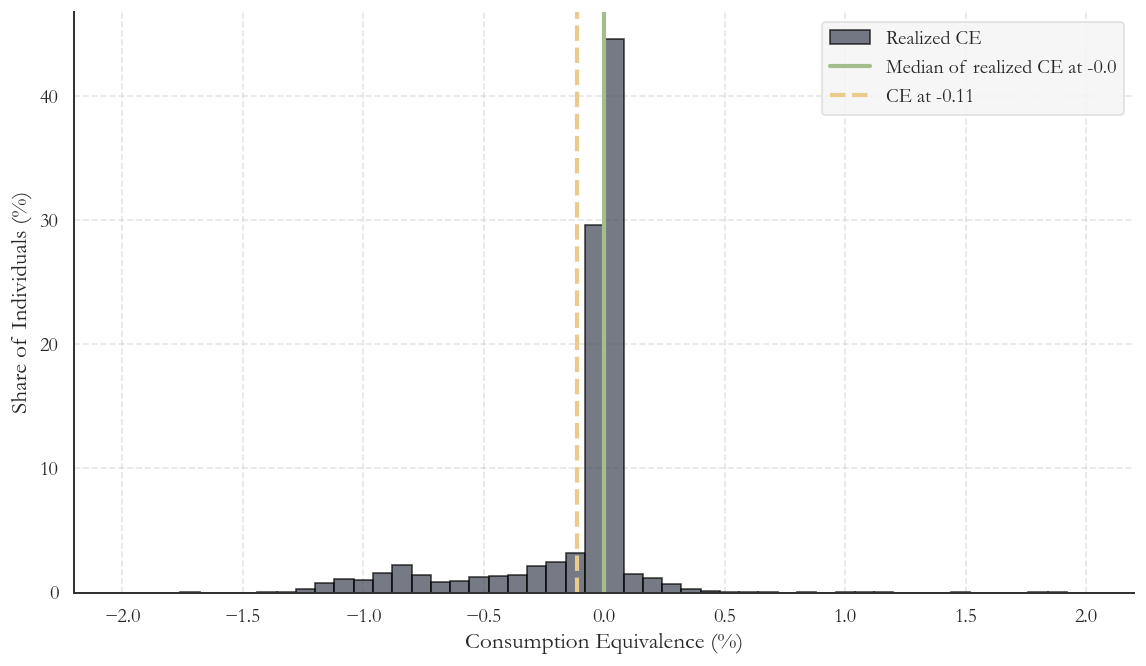

In [7]:
con_eq = analytical_consumption_equivalence_indi(og_model, new_model)
plot_event_histogram(con_eq[:]*100, 'Consumption Equivalence (%)', 
                    #  'Consumption Equivalence Distribution for a 30-year-old',
                         label1="Realized CE",
                         figsize=(10, 6), bins=50, range=(-2,2), median_val=np.median(con_eq)*100, mean_val =np.mean(con_eq)*100, save_title='CF_means_testing_CE_dist')

# Unofficial retirement age

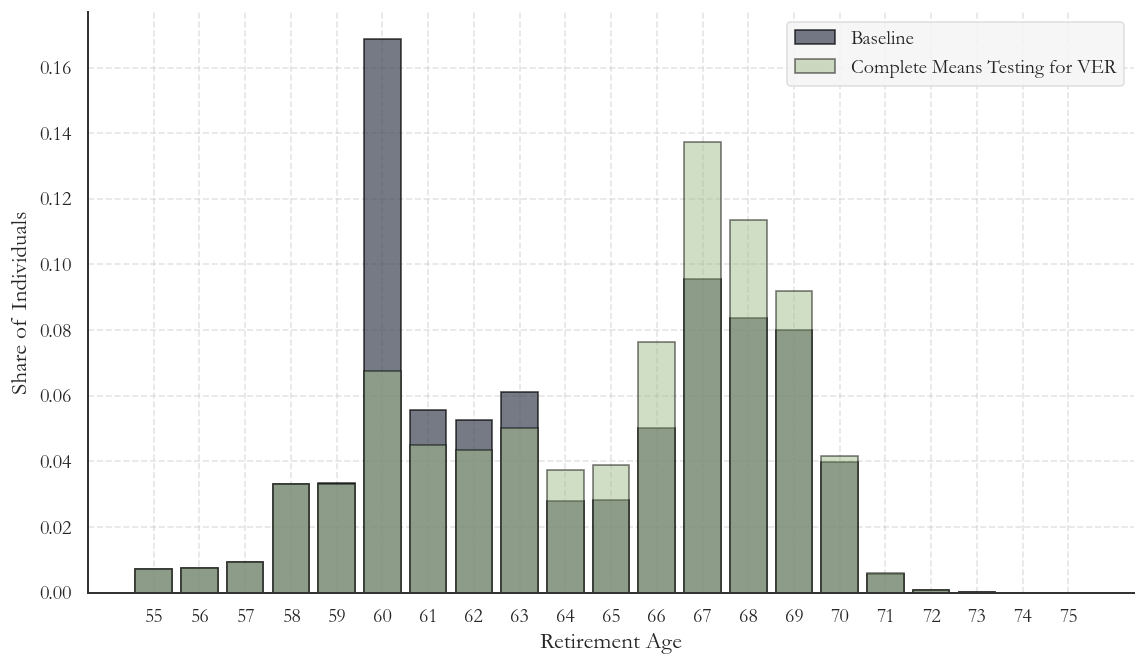

In [8]:
# 1. Find last time ex == 1 for each individual
last_working = np.full(og_model.sim.ex.shape[0], np.nan)  # initialize

for i in range(og_model.sim.ex.shape[0]):
    working = np.where(og_model.sim.ex[i, :] == 1)[0]  # find where ex=1
    if working.size > 0:
        last_working[i] = working[-1]  # last time they worked (take last index)

# 1. Find last time ex == 1 for each individual
last_working_new = np.full(new_model.sim.ex.shape[0], np.nan)  # initialize

for i in range(new_model.sim.ex.shape[0]):
    working_new = np.where(new_model.sim.ex[i, :] == 1)[0]  # find where ex=1
    if working_new.size > 0:
        last_working_new[i] = working_new[-1]  # last time they worked (take last index)

plot_event_bar_series(
    values1=last_working,
    values2=last_working_new,
    xlabel="Retirement Age",
    # title="Timing of Unofficial Retirement",
    label1="Baseline",
    label2="Complete Means Testing for VER",
    bins=np.arange(25, 46),
    save_title="CF_means_testing_un_ret.png",
)


# Official retirement age

In [9]:
def official_retirement(model):
    first_retirement = np.full(model.sim.e.shape[0], np.nan)  # initialize

    for i in range(model.sim.e.shape[0]):
        retired = np.where(model.sim.e[i, :] == 2)[0]  # find where e=2
        if retired.size > 0:
            first_retirement[i] = retired[0]  # first time they retire
        if model.sim.efter_init[i]:
            if len(model.sim.ex[i,:]) - np.argmax(model.sim.ex[i,:][::-1] == 1)< first_retirement[i]:
                first_retirement[i] = len(model.sim.ex[i,:]) - np.argmax(model.sim.ex[i,:][::-1] == 1)

    return first_retirement

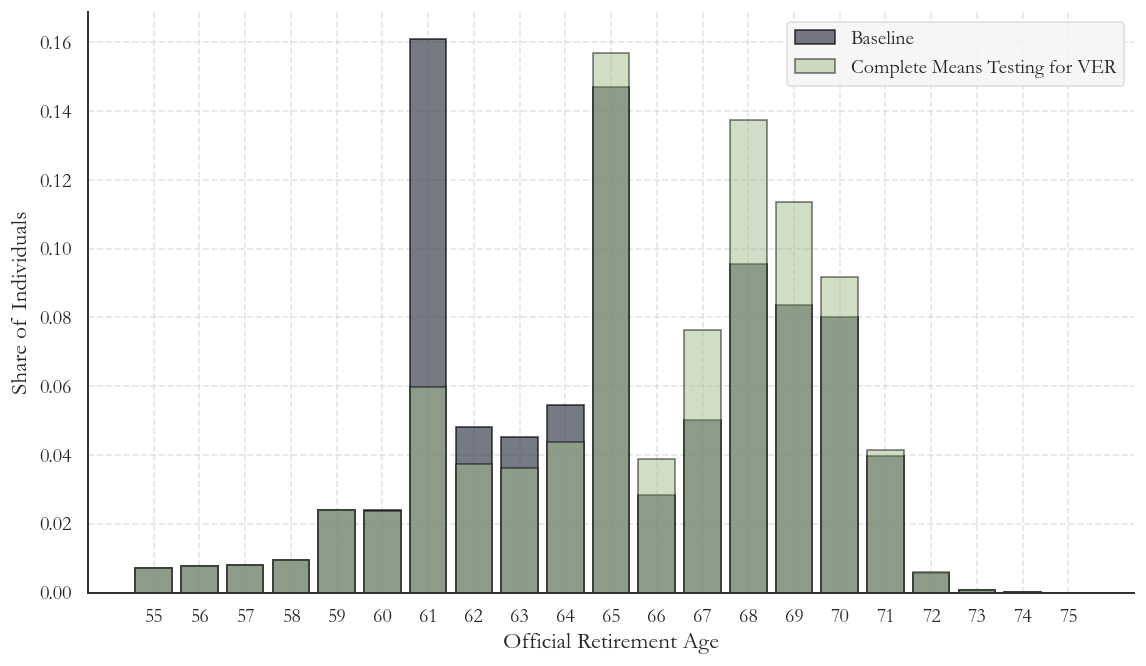

In [10]:
first_retirement_og = official_retirement(og_model)
first_retirement_new = official_retirement(new_model)

plot_event_bar_series(
    values1=first_retirement_og,
    values2=first_retirement_new,
    xlabel="Official Retirement Age",
    # title="Timing of Official Retirement",
    label1="Baseline",
    label2="Complete Means Testing for VER",
    bins=np.arange(25, 46),
    save_title="CF_means_testing_of_ret.png",
)


# Voluntary retirement age

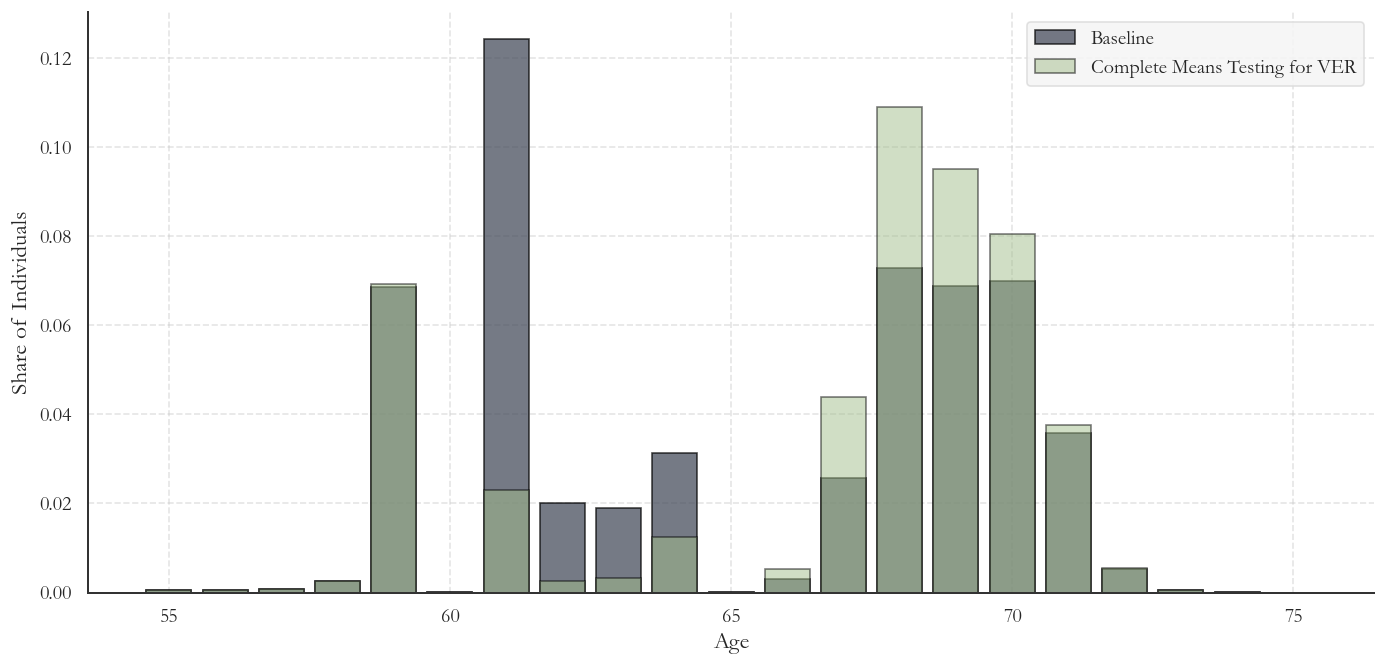

In [11]:
og_ret_counts = np.sum(og_model.sim.ret_flag[:, :], axis=0)
new_ret_counts = np.sum(new_model.sim.ret_flag[:, :], axis=0)
plot_bar_series_comparison(
    og_ret_counts,
    new_ret_counts,
    label1="Baseline",
    label2="Complete Means Testing for VER",
    # title="Voluntary Retirements per Period",
    xlabel="Age",
    normalize=True,
    t_start=25, 
    t_end=46,
    save_title="CF_means_testing_vol_ret.png",
)


# Consumption Replacement Rate

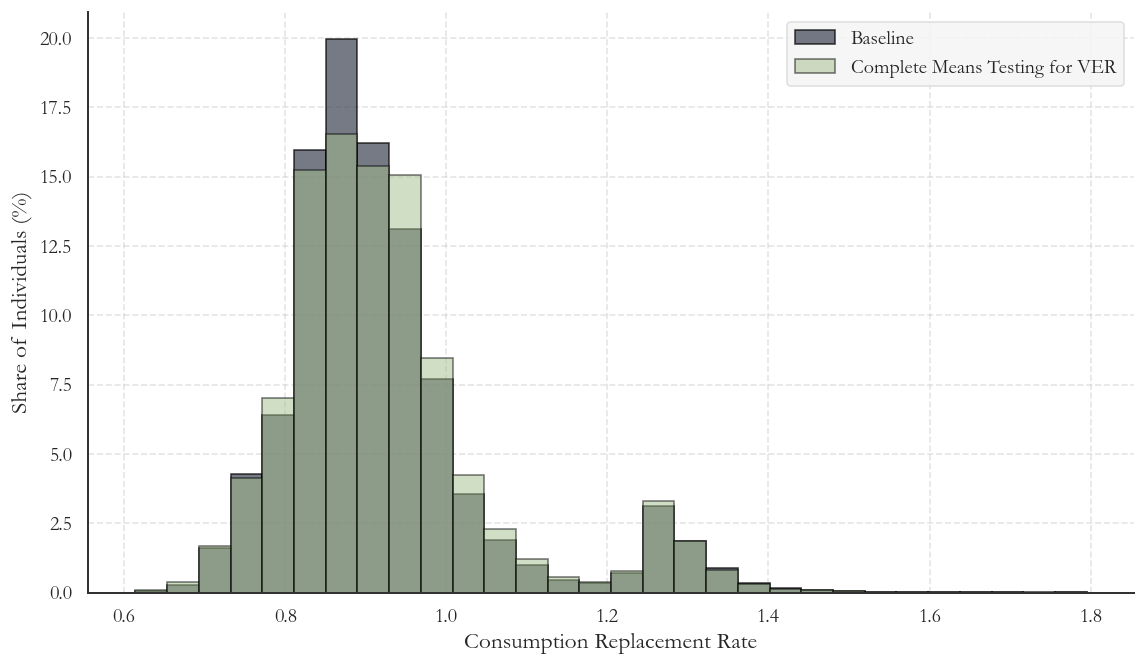

In [12]:
plot_event_histogram(
    values1=consumption_replacement_rate_fct(og_model),
    values2=consumption_replacement_rate_fct(new_model),
    xlabel="Consumption Replacement Rate",
    # title="Consumption Replacement Rate",
    label1="Baseline",
    label2="Complete Means Testing for VER",
    bins=30,
    save_title="CF_means_testing_CR.png",
)

# Replacement Rate

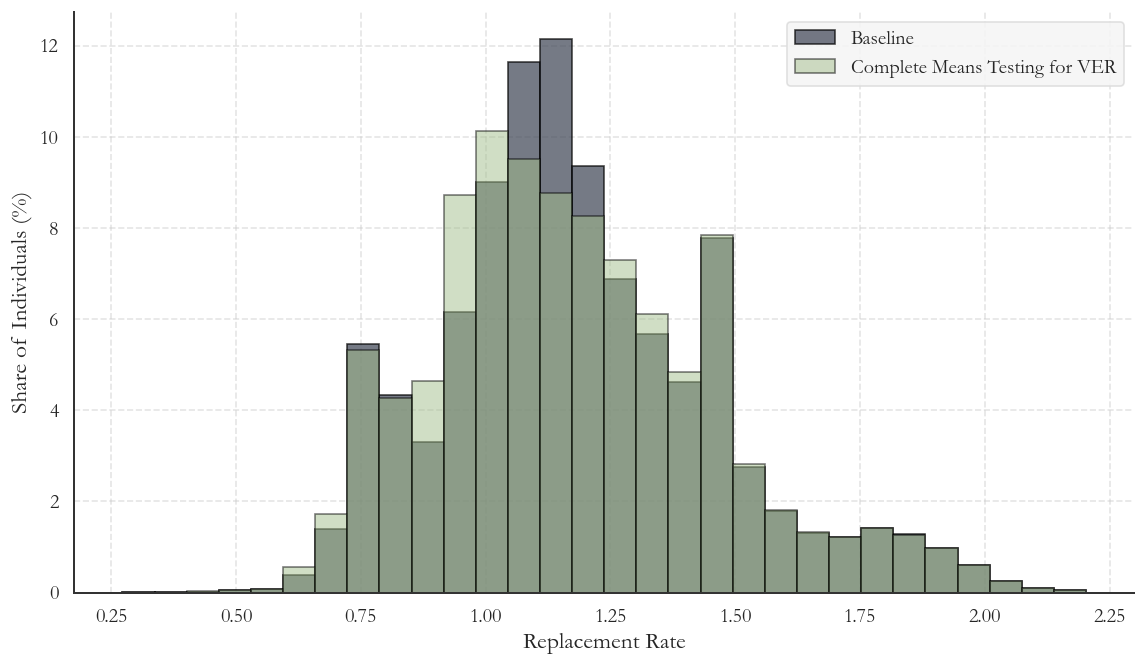

In [13]:
plot_event_histogram(
    values1=replacement_rate_fct(og_model),
    values2=replacement_rate_fct(new_model),
    xlabel="Replacement Rate",
    # title="Replacement Rate",
    label1="Baseline",
    label2="Complete Means Testing for VER",
    bins=30,
    save_title="CF_means_testing_RR.png"
)


# Consumption equivalence over Age

In [14]:
EV_age_new, EV_weight_new = ev_model(new_model)
phi_age, phi_avg = analytical_age_phi(og_model, EV_age_new)
plot_single_line_with_reference(
    line_data=phi_age,
    reference_value=phi_avg,
    label_line="CE each year",
    label_ref="Avg. CE",
    ylabel="Equivalence",
    scale=100,
    save_title="CF_means_testing_CE_age.png"
)

ValueError: too many values to unpack (expected 2)

# Comparison of means

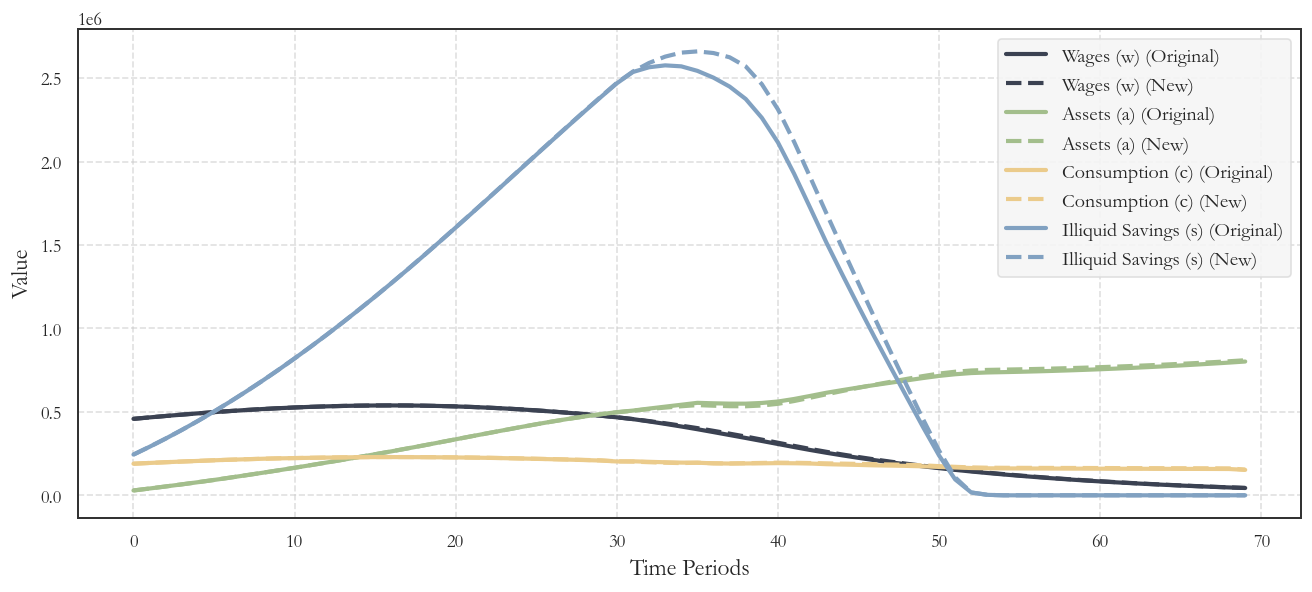

In [ ]:
time = np.arange(par.T)

# Data for selected summary variables
summary_vars = ["Wages (w)", "Assets (a)", "Consumption (c)", "Illiquid Savings (s)"]
simulated_data_new = {
    "Wages (w)": np.mean(new_model.sim.w[:], axis=0),
    "Assets (a)": np.mean(new_model.sim.a[:], axis=0),
    "Consumption (c)": np.mean(new_model.sim.c[:], axis=0),
    "Illiquid Savings (s)": np.mean(new_model.sim.s[:], axis=0),
}
simulated_data_og = {
    "Wages (w)": np.mean(og_model.sim.w[:], axis=0),
    "Assets (a)": np.mean(og_model.sim.a[:], axis=0),
    "Consumption (c)": np.mean(og_model.sim.c[:], axis=0),
    "Illiquid Savings (s)": np.mean(og_model.sim.s[:], axis=0),
}

plot_comparison_single_panel(simulated_data_og, simulated_data_new, summary_vars, time, save_title="CF_means_testing_means.png")
